In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import os,sys
import torchvision.transforms as transforms
# os.environ["https_proxy"]="10.10.20.100:1089"
# os.environ["https_proxy"]="127.0.0.1:7890"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
sys.path.append('..')
sys.path.append('.')
%load_ext autoreload
%autoreload 2

In [28]:
# LOAD VAE

import os
import time
from pathlib import Path
from loguru import logger
from datetime import datetime
import torch

from hyvideo.utils.file_utils import save_videos_grid
from hyvideo.config import parse_args
from hyvideo.inference import HunyuanVideoSampler
from hyvideo.vae.autoencoder_kl_causal_3d import AutoencoderKLCausal3D
import hyvideo.config
print(hyvideo.config.__file__)
from hyvideo.config import *
string_args="""--video-size 720 1280 --video-length 129 --infer-steps 50 --prompt cat. --flow-reverse --use-cpu-offload --save-path ./results"""
string_args=string_args.split(" ")
print(string_args)

def parse_args_with_string(string_args,namespace=None):
    parser = argparse.ArgumentParser(description="HunyuanVideo inference script")

    parser = add_network_args(parser)
    parser = add_extra_models_args(parser)
    parser = add_denoise_schedule_args(parser)
    parser = add_inference_args(parser)
    parser = add_parallel_args(parser)

    args = parser.parse_args(string_args,namespace=namespace)
    args = sanity_check_args(args)

    return args

args = parse_args_with_string(string_args=string_args)
print(args)

from hyvideo.modules import load_model
from hyvideo.vae import load_vae

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

vae, _, s_ratio, t_ratio = load_vae(
            args.vae,
            args.vae_precision,
            logger=logger,
            device=device,
        )
vae:AutoencoderKLCausal3D
vae.enable_tiling()


/mnt/public/hanling/mnt/public/hanling/miniconda3/envs/HunyuanVideo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-28 11:06:46.053 | INFO     | hyvideo.vae:load_vae:87 - Loading 3D VAE model (884-16c-hy) from: ./ckpts/hunyuan-video-t2v-720p/vae


detect you are not use the latest yunchang. Please install yunchang>=0.4.0
/mnt/public/wangsiyuan/HunyuanVideo_efficiency/hyvideo/config.py
['--video-size', '720', '1280', '--video-length', '129', '--infer-steps', '50', '--prompt', 'cat.', '--flow-reverse', '--use-cpu-offload', '--save-path', './results']
Namespace(model='HYVideo-T/2-cfgdistill', latent_channels=16, precision='bf16', rope_theta=256, vae='884-16c-hy', vae_precision='fp16', vae_tiling=True, text_encoder='llm', text_encoder_precision='fp16', text_states_dim=4096, text_len=256, tokenizer='llm', prompt_template='dit-llm-encode', prompt_template_video='dit-llm-encode-video', hidden_state_skip_layer=2, apply_final_norm=False, text_encoder_2='clipL', text_encoder_precision_2='fp16', text_states_dim_2=768, tokenizer_2='clipL', text_len_2=77, denoise_type='flow', flow_shift=7.0, flow_reverse=True, flow_solver='euler', use_linear_quadratic_schedule=False, linear_schedule_end=25, model_base='ckpts', dit_weight='ckpts/hunyuan-video

2025-01-28 11:06:48.375 | INFO     | hyvideo.vae:load_vae:113 - VAE to dtype: torch.float16


In [ ]:


# 读取视频文件
video_path = "processed_240p_videos/dance2.mp4"  # 替换为你的视频文件路径
cap = cv2.VideoCapture(video_path)

# 获取fps
fps = cap.get(cv2.CAP_PROP_FPS)

# 存储视频帧的亮度值
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # 将帧转换为灰度图并获取亮度值
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)  # 存储每帧的平均亮度

cap.release()

# 将帧转换为 numpy 数组
signal = np.array(frames)

signal=signal.reshape(signal.shape[0],-1)

print(signal.shape)

# 进行离散傅里叶变换
frequencies = np.fft.fft(signal,axis=0)
frequencies_magnitude = np.abs(frequencies).mean(axis=1)

fft_freq = np.fft.fftfreq(len(signal), 1/fps)

# 去除等于0的
frequencies_magnitude = frequencies_magnitude[1:]
fft_freq = fft_freq[1:]

# 频谱图
plt.figure(figsize=(12, 6))
plt.plot(np.abs(fft_freq),frequencies_magnitude,'x')
plt.title('Frequency Spectrum of Original Video')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.show()




In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def read_yuv_file(file_path, width, height, resize_width,resize_height):
    # 计算YUV文件的大小
    frame_size = width * height
    y_size = frame_size
    u_size = frame_size // 4
    v_size = frame_size // 4
    frames=[]
    with open(file_path, 'rb') as f:
        while True:
            # f.read(0)
            y = f.read(y_size)
            v = f.read(v_size)
            u = f.read(u_size)

            if not y or not u or not v:
                break  # 文件结束

            # 将字节数据转换为numpy数组
            Y = np.frombuffer(y, dtype=np.uint8).reshape((height, width))
            U = np.frombuffer(u, dtype=np.uint8).reshape((height // 2, width // 2))
            V = np.frombuffer(v, dtype=np.uint8).reshape((height // 2, width // 2))

            # 上采样U和V分量
            U_up = cv2.resize(U, (width, height), interpolation=cv2.INTER_LINEAR)
            V_up = cv2.resize(V, (width, height), interpolation=cv2.INTER_LINEAR)

            # 合并YUV分量为BGR格式
            yuv = cv2.merge((Y, U_up, V_up))
            bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
            bgr = cv2.resize(bgr,(resize_width,resize_height))
            frames.append(bgr)
    return frames

# 示例调用
# path="/mnt/public/wangsiyuan/k8bfn0qsj9fs1rwnc2x75z6t7/BVI-HFR/60hz/"


# # 读取视频文件
# video_path = path+"flowers-60fps-360-1920x1080.yuv"  # 替换为你的视频文件路径
# read_yuv_file(video_path, width=1920, height=1080)

guitar_focus-60fps-360-1920x1080.yuv
(600, 129600)
(32640, 150)


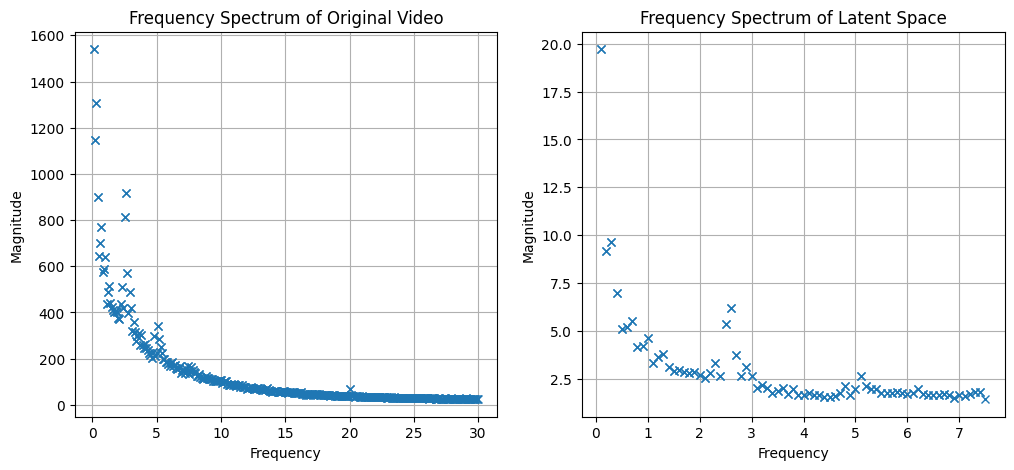

bobblehead-60fps-360-1920x1080.yuv
(600, 129600)


In [ ]:
path="/mnt/public/wangsiyuan/k8bfn0qsj9fs1rwnc2x75z6t7/BVI-HFR/60hz/"
fps = 60
for filename in os.listdir(path):
    if filename.endswith(".yuv"):
        print(filename)
        video_path = path+filename  # 替换为你的视频文件路径
        raw_frames=read_yuv_file(video_path, width=1920, height=1080,resize_width=1920//4,resize_height=1080//4)
        # 存储视频帧的亮度值
        frames=[]
        tensor_frames=[]
        for frame in raw_frames:
            # 将帧转换为灰度图并获取亮度值
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray_frame)  # 存储每帧的平均亮度
            tensor_frame = transforms.ToTensor()(frame)
            tensor_frames.append(tensor_frame)

        # 将帧转换为 numpy 数组
        signal = np.array(frames)

        signal=signal.reshape(signal.shape[0],-1)

        print(signal.shape)

        # 进行离散傅里叶变换
        frequencies = np.fft.fft(signal,axis=0)
        frequencies_magnitude = np.abs(frequencies).mean(axis=1)

        fft_freq = np.fft.fftfreq(len(signal), 1/fps)

        # 去除等于0的
        frequencies_magnitude = frequencies_magnitude[1:]
        fft_freq = fft_freq[1:]

        # 频谱图
        plt.figure(figsize=(12, 5))
        plt.title(filename)

        plt.subplot(1,2,1)
        plt.plot(np.abs(fft_freq),frequencies_magnitude,'x')
        plt.title('Frequency Spectrum of Original Video')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.grid()

        video_tensor = torch.stack(tensor_frames)          # (T, C, H, W)
        video_tensor = video_tensor.permute(1, 0, 2, 3)  # (C, T, H, W)
        video_tensor = 2 * video_tensor - 1         # [-1, 1]范围

        x=video_tensor.unsqueeze(0).half().cuda()
        y=vae.encode(x)

        signal = y.latent_dist.mean.permute(0,1,3,4,2)
        signal = signal.reshape(-1,signal.shape[-1]).cpu().numpy()

        print(signal.shape)

        # 进行离散傅里叶变换
        frequencies = np.fft.fft(signal,axis=1)
        frequencies_magnitude = np.abs(frequencies).mean(axis=0)
        frequencies_magnitude = frequencies_magnitude[1:]

        fft_freq = np.fft.fftfreq(signal.shape[1], 4/fps)
        fft_freq = fft_freq[1:]

        # 频谱图
        plt.subplot(1,2,2)
        plt.plot(np.abs(fft_freq),frequencies_magnitude,'x')
        plt.title('Frequency Spectrum of Latent Space')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.show()
